<font color = 'green'><h1>Image Captioning</h1></font>
* Generating captions for images

In [116]:
import string
import pandas as pd
import numpy as np
import pickle
from time import time
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, add

In [3]:
# Read Text captions
 
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
        
    return captions

In [4]:
captions = readTextFile('Desktop/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt' )

In [5]:
captions.split(sep='\n')
#len(captions.split(sep='\n')) = 40461

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint sits in front of a pai

In [6]:
captions = captions.split('\n')[:-1]
captions[0]

'1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [7]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

In [8]:
# Dictionary to map each image to the list of captions contained within 

descriptions = {}
for x in captions : 
    first, second = x.split('\t')
    img_name = first.split('.')[0]
    
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []
        
    descriptions[img_name].append(second)

In [9]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [10]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

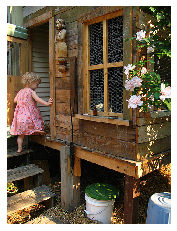

In [11]:
IMG_PATH = 'Desktop/flickr8k/Flickr_Data/Flickr_Data/Images'

img = cv2.imread(IMG_PATH + '/1000268201_693b08cb0e.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

<font color = 'blue'><h1>Data Cleaning</h1></font>

In [12]:
import re
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+',' ', sentence)
    sentence = sentence.split()
    
    #sentence = [s for s in sentence if len(s)>1]
    sentence = ' '.join(sentence)
    
    return sentence

In [13]:
# Clean all captions : 
for key, caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])
    

In [14]:
descriptions['1000268201_693b08cb0e']

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

In [15]:
with open('Desktop/flickr8k/Flickr_Data/Flickr_Data/descriptions.txt','w') as f:
    f.write(str(descriptions))

<font color = 'blue'><h1>Creating Vocab</h1></font>

In [16]:
import json
descriptions = None
with open('Desktop/flickr8k/Flickr_Data/Flickr_Data/descriptions.txt','r') as f:
    descriptions = f.read()
    

acceptable_string = descriptions.replace("'","\"")    
descriptions = json.loads(acceptable_string)

In [17]:
type(descriptions)

dict

In [18]:
# Vocab

vocab = set()

for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]] 
    
print('Vocab size: ', len(vocab))

Vocab size:  8441


In [19]:
#vocab

In [20]:
# Total Words

total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print(len(total_words))

437466


In [21]:
### Reducing vocab by taking frequency of unique words into account...

import collections
counter = collections.Counter(total_words)
freq_count = dict(counter)
freq_count

{'a': 62995,
 'child': 1545,
 'in': 18987,
 'pink': 739,
 'dress': 348,
 'is': 9345,
 'climbing': 507,
 'up': 1302,
 'set': 109,
 'of': 6723,
 'stairs': 109,
 'an': 2432,
 'entry': 1,
 'way': 53,
 'girl': 3328,
 'going': 149,
 'into': 1074,
 'wooden': 284,
 'building': 511,
 'little': 1768,
 'playhouse': 6,
 'the': 18420,
 'to': 3176,
 'her': 1178,
 'cabin': 4,
 'black': 3848,
 'dog': 8138,
 'and': 8863,
 'spotted': 38,
 'are': 3505,
 'fighting': 133,
 'tri': 14,
 'colored': 221,
 'playing': 2008,
 'with': 7765,
 'each': 430,
 'other': 773,
 'on': 10746,
 'road': 398,
 'white': 3959,
 'brown': 2578,
 'spots': 29,
 'staring': 57,
 'at': 2916,
 'street': 944,
 'two': 5643,
 'dogs': 2125,
 'different': 46,
 'breeds': 5,
 'looking': 744,
 'pavement': 48,
 'moving': 41,
 'toward': 146,
 'covered': 372,
 'paint': 62,
 'sits': 577,
 'front': 1386,
 'painted': 64,
 'rainbow': 22,
 'hands': 246,
 'bowl': 30,
 'sitting': 1368,
 'large': 1237,
 'small': 1278,
 'grass': 1622,
 'plays': 526,
 'fing

In [22]:
len(freq_count)

8441

In [23]:
newdict = dict()

def filter_dict(dictionary):
    for key, value in dictionary.items():
        if value > 5:
            newdict[key] = value
    return newdict

new_freq_count = filter_dict(freq_count)

In [24]:
(new_freq_count)
#print(len(new_freq_count))

{'a': 62995,
 'child': 1545,
 'in': 18987,
 'pink': 739,
 'dress': 348,
 'is': 9345,
 'climbing': 507,
 'up': 1302,
 'set': 109,
 'of': 6723,
 'stairs': 109,
 'an': 2432,
 'way': 53,
 'girl': 3328,
 'going': 149,
 'into': 1074,
 'wooden': 284,
 'building': 511,
 'little': 1768,
 'playhouse': 6,
 'the': 18420,
 'to': 3176,
 'her': 1178,
 'black': 3848,
 'dog': 8138,
 'and': 8863,
 'spotted': 38,
 'are': 3505,
 'fighting': 133,
 'tri': 14,
 'colored': 221,
 'playing': 2008,
 'with': 7765,
 'each': 430,
 'other': 773,
 'on': 10746,
 'road': 398,
 'white': 3959,
 'brown': 2578,
 'spots': 29,
 'staring': 57,
 'at': 2916,
 'street': 944,
 'two': 5643,
 'dogs': 2125,
 'different': 46,
 'looking': 744,
 'pavement': 48,
 'moving': 41,
 'toward': 146,
 'covered': 372,
 'paint': 62,
 'sits': 577,
 'front': 1386,
 'painted': 64,
 'rainbow': 22,
 'hands': 246,
 'bowl': 30,
 'sitting': 1368,
 'large': 1237,
 'small': 1278,
 'grass': 1622,
 'plays': 526,
 'canvas': 6,
 'it': 401,
 'there': 304,
 'pig

In [25]:
new_vocab = [key for (key, value) in new_freq_count.items()]
print(new_vocab)

['a', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'way', 'girl', 'going', 'into', 'wooden', 'building', 'little', 'playhouse', 'the', 'to', 'her', 'black', 'dog', 'and', 'spotted', 'are', 'fighting', 'tri', 'colored', 'playing', 'with', 'each', 'other', 'on', 'road', 'white', 'brown', 'spots', 'staring', 'at', 'street', 'two', 'dogs', 'different', 'looking', 'pavement', 'moving', 'toward', 'covered', 'paint', 'sits', 'front', 'painted', 'rainbow', 'hands', 'bowl', 'sitting', 'large', 'small', 'grass', 'plays', 'canvas', 'it', 'there', 'pigtails', 'painting', 'young', 'outside', 'man', 'lays', 'bench', 'while', 'his', 'by', 'him', 'which', 'also', 'tied', 'sleeping', 'next', 'shirtless', 'lies', 'park', 'laying', 'holding', 'leash', 'ground', 'orange', 'hat', 'starring', 'something', 'wears', 'glasses', 'wearing', 'beer', 'can', 'pierced', 'ears', 'rope', 'net', 'red', 'climbs', 'bridge', 'onto', 'ropes', 'playground', 'running', 'grassy', 'garde

<font color = 'blue'><h1>Data Preprocessing</h1></font>
## - Images
## - Text

In [26]:
train_file_data = readTextFile('Desktop/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt')
test_file_data = readTextFile('Desktop/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt')

In [27]:
train_file_data[-1]

'\n'

In [28]:
train = train_file_data.split('\n')[:-1]
train = [s.split('.')[0] for s in train]
#print(train)

test = test_file_data.split('\n')[:-1]
test = [s.split('.')[0] for s in test]

In [29]:
train_description = {}

for img_id in train:
    train_description[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = 'startseq ' + cap + ' endseq'
        train_description[img_id].append(cap_to_append)

# Transfer Learning
- Images --> Features
- Text --> Features

<font color = 'green'><h1>Step1 - Image Feature Extraction</h1></font>

In [30]:
model = ResNet50(weights = 'imagenet', input_shape = (224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [31]:
new_model = Model(model.input, model.layers[-2].output)

In [32]:
def preprocess_img(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    
    # Normalization
    img = preprocess_input(img)
    return img

In [33]:
#img = preprocess_img('Desktop/flickr8k/Flickr_Data/Flickr_Data/Images/1001773457_577c3a7d70.jpg')
#plt.imshow(img[0])
#plt.axis('off')
#plt.show()
#print(img)

In [34]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = new_model.predict(img).reshape((2048,))
    #print(feature_vector.shape)
    
    return feature_vector

In [35]:
encode_img('Desktop/flickr8k/Flickr_Data/Flickr_Data/Images/1002674143_1b742ab4b8.jpg')

array([0.07192714, 0.52196074, 0.17953326, ..., 0.        , 3.0663972 ,
       1.3550673 ], dtype=float32)

###  Train Encoding

In [36]:
start_time = time()
encoding_train = {}

for ix, img_id in enumerate(train):
    img_path = IMG_PATH + '/'+ img_id + '.jpg'
    encoding_train[img_id] = encode_img(img_path)
    
    if ix%100 == 0 :
        print('Encoding in progress... Time setep: ', ix)
        
end_time = time()

print('Total time taken to encode : ', (end_time-start_time))

Encoding in progress... Time setep:  0
Encoding in progress... Time setep:  100
Encoding in progress... Time setep:  200
Encoding in progress... Time setep:  300
Encoding in progress... Time setep:  400
Encoding in progress... Time setep:  500
Encoding in progress... Time setep:  600
Encoding in progress... Time setep:  700
Encoding in progress... Time setep:  800
Encoding in progress... Time setep:  900
Encoding in progress... Time setep:  1000
Encoding in progress... Time setep:  1100
Encoding in progress... Time setep:  1200
Encoding in progress... Time setep:  1300
Encoding in progress... Time setep:  1400
Encoding in progress... Time setep:  1500
Encoding in progress... Time setep:  1600
Encoding in progress... Time setep:  1700
Encoding in progress... Time setep:  1800
Encoding in progress... Time setep:  1900
Encoding in progress... Time setep:  2000
Encoding in progress... Time setep:  2100
Encoding in progress... Time setep:  2200
Encoding in progress... Time setep:  2300
Enco

In [37]:
with open('encoded_train_features.pkl', 'wb') as f:
    pickle.dump(encoding_train, f)

###  Test Encoding

In [38]:
start_time = time()
encoding_test = {}

for ix, img_id in enumerate(test):
    img_path = IMG_PATH + '/'+ img_id + '.jpg'
    encoding_test[img_id] = encode_img(img_path)
    
    if ix%100 == 0 :
        print('Encoding in progress... Time setep: ', ix)
        
end_time = time()

print('Total time taken for test data to encode : ', (end_time-start_time))

Encoding in progress... Time setep:  0
Encoding in progress... Time setep:  100
Encoding in progress... Time setep:  200
Encoding in progress... Time setep:  300
Encoding in progress... Time setep:  400
Encoding in progress... Time setep:  500
Encoding in progress... Time setep:  600
Encoding in progress... Time setep:  700
Encoding in progress... Time setep:  800
Encoding in progress... Time setep:  900
Total time taken for test data to encode :  314.8902509212494


In [39]:
with open('encoded_test_features.pkl', 'wb') as f:
    pickle.dump(encoding_test, f)

## Text Preprocessing

In [88]:
len(new_vocab)

2644

In [162]:
word_to_idx = {}
idx_to_word = {}

for i, word in enumerate(new_vocab):
    word_to_idx[word] = i+1 
    idx_to_word[i+1] = word
    
    
word_to_idx['startseq'] = 2645
idx_to_word[2645] = 'startseq'

word_to_idx['endseq'] = 2646
idx_to_word[2646] = 'endseq'

print('Vocab size is : ', len(idx_to_word)+1)

Vocab size is :  2647


In [163]:
vocab_size = len(idx_to_word)+1

In [164]:
# Use fixed length of caption(maximum length) of training des. while training the dataset.
l = []
for key in train_description.keys():
    for cap in train_description[key]:
        l.append(len(cap.split()))
        
print('Max length of caption amongst all captions: ', max(l))

Max length of caption amongst all captions:  38


## Data Loader (Generator) 

In [184]:
def data_generator(train_description, encoding_train, word_to_idx, max_length, batch_size):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in train_description.items():
            n+=1
            # retrieve the photo feature
            photo = encoding_train[key]
            for desc in desc_list:
                # encode the sequence
                seq = [word_to_idx[word] for word in desc.split(' ') if word in word_to_idx]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==batch_size:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

# Word Embeddings

In [167]:
f = open('Desktop/Image captioning project/glove.6B.50d.txt', encoding='utf-8')

In [168]:
embedding_index = {}
for line in f:
    values = line.split()
    #print(values)
    word = values[0]
    embedding_word = np.array(values[1:], dtype = 'float')
    embedding_index[word] = embedding_word

In [169]:
embedding_index['apple'] 

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [170]:
f.close()

In [171]:
def get_embedding_matrix():
    embed_dim = 50
    matrix = np.zeros((vocab_size, embed_dim))
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector

    return matrix

In [172]:
embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(2647, 50)


## Model Architecture

In [187]:
# Image feature extraction
input_img_features = Input((2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [188]:
# Captions as input()

input_captions = Input(shape = (max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [189]:
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation = 'softmax')(decoder2)

# Combined Model:
model = Model(inputs = [input_img_features,input_captions], outputs = outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 38)           0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 38, 50)       132350      input_16[0][0]                   
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 2048)         0           input_15[0][0]                   
____________________________________________________________________________________________

In [190]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [191]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam')


## Training Model

In [192]:
epochs = 20
batch_size = 3
steps = len(train_description)//batch_size

In [193]:
for i in range(epochs):
    generator = data_generator(train_description, encoding_train, word_to_idx, max_length=38, batch_size=3)
    model.fit_generator(generator, epochs = 1, steps_per_epoch=steps, verbose=1)
    
model.save_weights('model.h5')

Epoch 1/1
2000/2000 [==============================] - 1260s 630ms/step - loss: 3.9798
Epoch 1/1
2000/2000 [==============================] - 1177s 588ms/step - loss: 3.2590
Epoch 1/1
2000/2000 [==============================] - 1580s 790ms/step - loss: 3.0044
Epoch 1/1
2000/2000 [==============================] - 1503s 751ms/step - loss: 2.8481
Epoch 1/1
2000/2000 [==============================] - 1416s 708ms/step - loss: 2.7364
Epoch 1/1
2000/2000 [==============================] - 1483s 742ms/step - loss: 2.6508
Epoch 1/1
2000/2000 [==============================] - 1290s 645ms/step - loss: 2.5806
Epoch 1/1
2000/2000 [==============================] - 1660s 830ms/step - loss: 2.5272
Epoch 1/1
2000/2000 [==============================] - 1989s 994ms/step - loss: 2.4799
Epoch 1/1
2000/2000 [==============================] - 1439s 719ms/step - loss: 2.4443
Epoch 1/1
2000/2000 [==============================] - 1305s 652ms/step - loss: 2.4088
Epoch 1/1
2000/2000 [======================

# <font color = 'red'>Predicting Captions

In [212]:
def predict_caption(photo):
    inp_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_idx[word] for word in inp_text.split() if word in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        ypred = model.predict([photo,sequence])
        # Greedy Sampling -- word selection with maximum probability
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        inp_text += (' ' + word)
        
        if word == 'endseq':
            break
            
    final_caption = inp_text.split()[1:-1]
    final_caption = (' '.join(final_caption))
    
    return final_caption

a man in a grey shirt is hanging on a rock


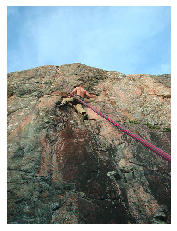

a boy in a red shirt is holding a baby in a hospital


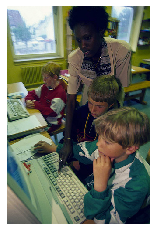

a man in a grey t shirt is rock climbing


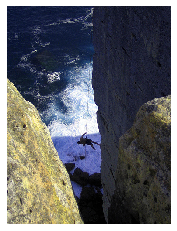

a man is rock climbing


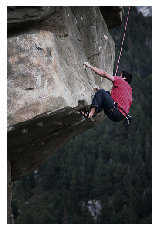

a dog is digging on a bone of wood


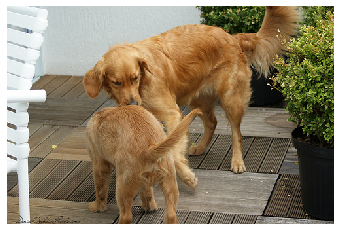

a raft car of a giant raft


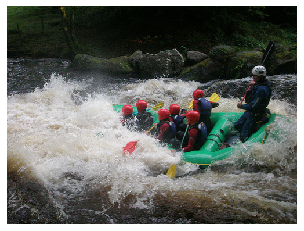

a man in a red shirt and bow tie is standing in front of a crowd


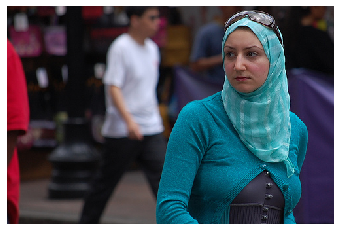

a man in a blue shirt is walking on a bench


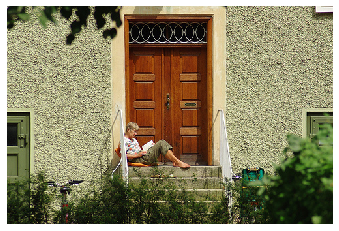

a soccer player in red is challenging the player in white for the ball


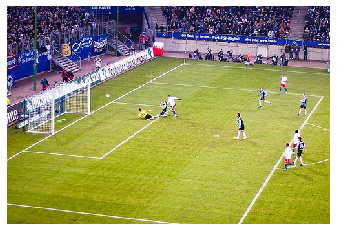

a black pelican is running through the water


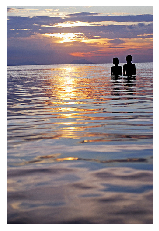

a dog running through the snow


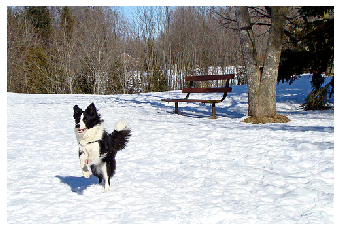

a little girl in a pink shirt is holding a towel of a sparkler of water


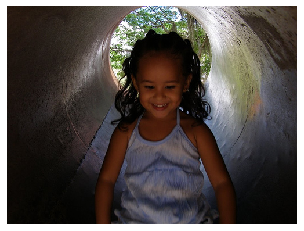

a little girl in a red dress is holding a camera


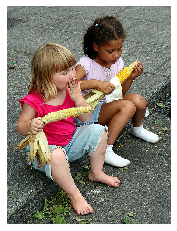

a bike rider jumping high in the air


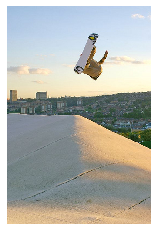

a group of people are standing in front of a building


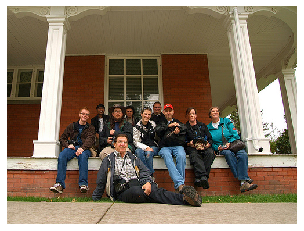

In [214]:
# Pick random images and see results:

for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread('Dropbox/flickr8k/Flickr_Data/Flickr_Data/Images/' + img_name + '.jpg')
    caption = predict_caption(photo_2048)
    print(caption)
    plt.imshow(i)
    plt.axis('off')
    plt.show()